# SVM Soft Margin

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Shin Dong-hyeok(tlsehdgur0@kaist.ac.kr); Kim Hye-mi(khm0308@kaist.ac.kr) </div>

본 코드는 Support Vector Machine의 Soft Margin을 이용하여 Decision Boundary를 찾아내는 구현 예시입니다.  
본 코드를 통하여 본 코드는 2차원 평면에 label되어있는 데이터를 Soft Margin을 이용하여 분류할 수 있습니다.

### Hard Margin
앞선 코드에서 Margin을 최대화하여 데이터를 분류하였습니다. 하지만 실제로 선 하나로 데이터를 완벽하게 나눌 수 있는 경우는 드물며, 아래의 그림처럼 새로운 선을 긋는다고 할지라도 두 종류의 점을 완벽하게 나눌 수 없는 경우가 존재합니다.

<img src="hardMargin.PNG">

위와 같이 어떠한 에러도 허용하지 않고 Decision Boundary를 기준으로 Classification을 수행하는 것을 Hard Margin이라고 합니다. 이 모델은 에러가 존재할 수 있는 현실에는 적용하기 어려운 모델입니다. 따라서 에러의 일부를 인정하되 패널티를 부과하는 방식으로 Decision Boundary를 결정함으로써 위의 모델을 보완할 수 있습니다. 이러한 방식을 Soft Margin SVM이라 이릅니다.

### Soft Margin과 패널티 (Hinge Loss)
본 코드에서는 Margin Distance를 최대화 할 때, 목적함수 $\min_{w,b}(\rVert w \rVert)$에 에러와 관련된 항을 추가하여 에러를 처리합니다.  
에러가 난 경우에 대해서 'Hinge Loss'함수를 이용하여 거리만큼 패널티를 부과하여 에러를 다룰 수 있습니다. 이는 분류가 잘못 되었을 때 Slack Variable $\xi$를 $\xi_j>1$로 두어 나타낼 수 있습니다.  
Hard Margin에서 이용한 수식을 위의 과정에 따라 보완하면 다음과 같이 나타납니다.

$$min_{w,b}(\rVert w \rVert) + C\space\Sigma_j \xi_j$$
$$s.t.\space(wx_{j}+b)y_{j} \ge 1 - \xi_j, \forall j$$
$$\xi_j \ge 0, \forall j$$

여기서 추가적으로 $C$라는 새로운 매개변수를 설정해줍니다. $C$는 Slack Variable에 대해서 목적 함수에 어느 정도로 영향을 줄지를 결정하는 절충 매개변수입니다. 본 코드에서는 $C$ 값에 따른 Decision Boundary의 변화를 살펴볼 예정입니다.


In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr; Kim Hye-mi: khm0308@kaist.ac.kr
'''
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Positive / Negative 데이터 생성
#pos = np.array([[3, 7], [4, 6], [5, 6], [7, 7], [8, 5], [5, 5.2], [7, 5]])
pos = np.array([[3, 7], [4, 6], [5, 6], [7, 7], [8, 5], [5, 5.2], [7, 5], [6, 3.8]])
neg = np.array([[4, 5], [5, 5], [6, 3], [7, 4], [9, 4]])

# X: 전체 데이터를 저장
X = np.ones((pos.shape[0]+neg.shape[0], 2))
X[0:pos.shape[0], :] = pos # 앞부분은 positive 데이터를 저장
X[pos.shape[0]:pos.shape[0]+neg.shape[0], :] = neg # 뒷부분은 negative 데이터를 저장

# Y: 전체 데이터에 대한 label을 저장
Y = np.ones(pos.shape[0] + neg.shape[0])
Y[0:pos.shape[0]] = 1 # 앞부분은 positive 데이터에 대한 label로 +1을 저장
Y[pos.shape[0]:pos.shape[0]+neg.shape[0]] = -1 # 뒷부분은 negative 데이터에 대한 label로 -1을 저장

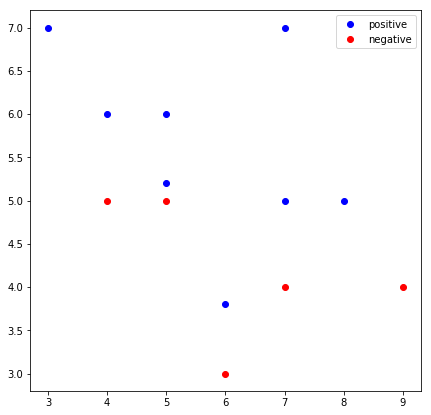

In [4]:
# 전체 데이터를 2차원 평면에 plot하는 과정
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
plt.legend()
plt.show()

### Hard Margin

In [5]:
# A: w벡터와 상수의 계수로 이루어진 행렬
# A[j, 0:X.shape[1]] = -xji＊yj (부등호 방향을 맞춰주기 위해 (-1)을 곱함)
# A[j, X.shape[1]+1] = -b
A = np.zeros((X.shape[0], X.shape[1] + 1))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        A[i, j] = X[i, j]*Y[i]*(-1) # -xij＊yi
    A[i, -1] = Y[i]*(-1) # -bi

# b: optimization problem에서 제약식 우측항의 값 (위의 b값이 아닌, optimal problem의 제약식에서의 b값임)
b = np.ones(X.shape[0]) * (-1)

# H: 목적항(w1^2+w2^2)에서 w의 quadratic term의 계수 (1)
H = np.zeros((X.shape[1] + 1, X.shape[1] + 1))
for i in range(X.shape[1]):
    H[i, i] = 1

# f: 목적항(w1^2+w2^2)에서 w의 일차항의 계수 (0)
f = np.zeros(X.shape[1] + 1)

H = matrix(H)
f = matrix(f)
A = matrix(A)
b = matrix(b)

sol = solvers.qp(H, f, A, b) # min 1/2xTHx+fTx s.t. Ax =< b
w = sol['x'] # x의 해, w1, w2는 결정 경계선의 수선방향의 벡터, w3는 상수항

     pcost       dcost       gap    pres   dres
 0:  1.3218e-01  1.8173e+01  4e+01  2e+00  4e+01
 1:  8.6125e-02  4.2565e+01  2e+01  1e+00  2e+01
 2:  4.2656e-04  1.6475e+02  3e+01  1e+00  2e+01
 3:  3.0308e-04  6.2258e+02  6e+01  1e+00  2e+01
 4:  1.4228e-04  3.1310e+03  2e+02  1e+00  2e+01
 5:  3.2427e-05  3.2078e+04  9e+02  1e+00  2e+01
 6:  9.7930e-07  9.9624e+05  5e+03  1e+00  1e+01
 7:  2.0175e-09  2.0075e+08  4e+04  1e+00  1e+01
 8:  5.0795e-13  9.3249e+11  3e+06  1e+00  1e+01
 9:  2.5531e-16  2.7195e+17  3e+10  1e+00  2e+04
10:  7.8797e-18  2.3361e+24  4e+16  1e+00  6e+08
11:  9.8550e-21  1.1750e+32  8e+22  1e+00  7e+16
12:  8.7155e-21  1.5932e+40  1e+31  1e+00  2e+25
13:  8.8241e-21  2.1563e+45  1e+36  1e+00  2e+30
14:  9.1309e-21  7.2336e+48  5e+39  1e+00  4e+37
15:  9.2320e-21  3.3488e+50  2e+41  1e+00  6e+42
16:  9.9272e-21  9.3581e+50  6e+41  1e+00  2e+47
17:  8.6331e-21  9.5807e+50  6e+41  1e+00  1e+50
Terminated (singular KKT matrix).


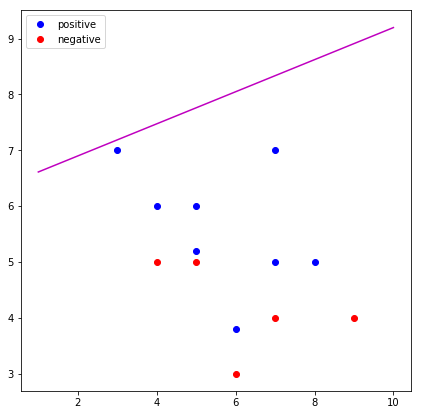

In [6]:
plt.figure(1, figsize = (7, 7))
plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
plt.legend()

lineX = [1, 10]

lineY0 = [(w[2] + w[0]*lineX[0])/-w[1], (w[2] + w[0]*lineX[1])/-w[1]]
plt.plot(lineX, lineY0, 'm-')
plt.show()

### 결과해석부
Hard Margin으로 해당 데이터 셋의 Classification을 수행했을 때, Optimization problem의 결과가 "Terminated (singular KKT matrix)."로 나타나는 것을 확인할 수 있습니다. 이는 cvxopt의 solver가 최적해를 찾지 못하고 terminated된 지점의 값을 결과로 출력함을 의미합니다. (KKT matrix가 singular하여 X의 값을 찾을 수 없습니다.) 실제로 해당 Optimization problem은 infeasible하며, Decision Boundary는 임의의 값으로 그려지고 있음을 확인할 수 있습니다.

### Soft Margin (Hinge Loss Function)

1. C = 0.1

     pcost       dcost       gap    pres   dres
 0:  4.6495e-01  6.5643e+00  7e+01  2e+00  5e+01
 1:  2.5896e+00 -2.0827e-02  3e+00  3e-02  6e-01
 2:  1.0197e+00  7.9674e-01  2e-01  1e-03  2e-02
 3:  9.3213e-01  9.0787e-01  2e-02  9e-05  2e-03
 4:  9.2107e-01  9.1891e-01  2e-03  6e-06  1e-04
 5:  9.2006e-01  9.1994e-01  1e-04  1e-07  2e-06
 6:  9.2001e-01  9.1999e-01  1e-05  4e-11  9e-10
 7:  9.2000e-01  9.2000e-01  2e-06  4e-16  3e-11
 8:  9.2000e-01  9.2000e-01  2e-07  2e-16  9e-11
Optimal solution found.
0.7992831665938135

2. C = 0.3

     pcost       dcost       gap    pres   dres
 0:  6.3917e-01  1.1395e+01  7e+01  3e+00  4e+01
 1:  6.9043e+00  1.9039e+00  5e+00  6e-16  3e-14
 2:  2.7110e+00  2.1730e+00  5e-01  6e-16  3e-15
 3:  2.4487e+00  2.3997e+00  5e-02  8e-16  1e-14
 4:  2.4231e+00  2.4198e+00  3e-03  5e-16  4e-14
 5:  2.4212e+00  2.4211e+00  5e-05  4e-16  2e-13
 6:  2.4212e+00  2.4212e+00  5e-07  4e-16  2e-12
Optimal solution found.
1.0779787198788908e-07

3. C

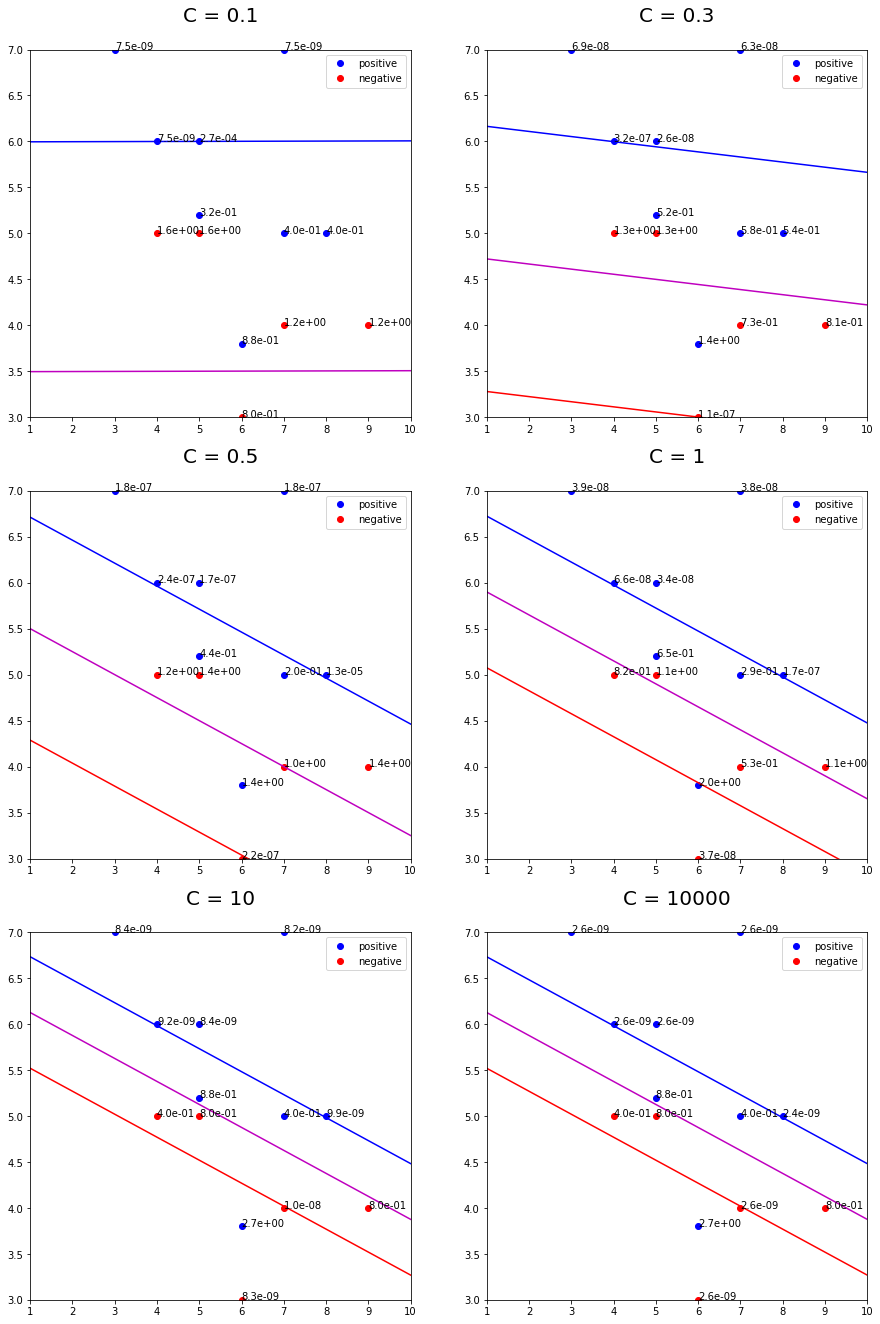

In [9]:
plt.figure(1, figsize = (15, 23))
C = [0.1, 0.3, 0.5, 1, 10, 10000]
for itr in range(len(C)):
    print('%s. C = %s\n'%(itr + 1, C[itr]))
    
    # A: optimization problem에서 제약식 좌측항의 w의 계수(부등호 방향을 맞춰주기 위해 (-1)을 곱함)
    A = np.zeros((X.shape[0] + X.shape[0], X.shape[1] + 1 + X.shape[0]))
    
    for i in range(X.shape[0]): # for문 에서 제약식에서 (wx+b)y+e>=1 항의 좌측항을 업데이트함
        for j in range(X.shape[1]):
            #A[i, j] = X[i, j]*Y[i]
            A[i, j] = X[i, j]*Y[i]*(-1) # -xij＊yi
        #A[i, X.shape[1]] = Y[i]
        A[i, X.shape[1]] = Y[i]*(-1) # -bi
        A[i, X.shape[1] + i + 1] = -1 # -ei (error)
    
    # 제약식에서 e>=0 항의 좌측항을 나타냄
    for i in range(X.shape[0]):
        A[i + X.shape[0], X.shape[1] + i + 1] = -1
    
    # b: optimization problem에서 제약식 우측항의 값
    b = np.zeros((X.shape[0] + X.shape[0], 1))
    # 제약식에서 (wx+b)y+e>=1 항의 우측항을 나타냄; e>=0 항의 우측항은 0으로 위에서 설정됨
    b[0:X.shape[0]] = -1
    
    # H: w의 quadratic term의 계수
    H = np.zeros((X.shape[1] + 1 + X.shape[0], X.shape[1] + 1 + X.shape[0]))
    for i in range(X.shape[1]):
        H[i, i] = 1

    f = np.zeros(X.shape[1] + 1 + X.shape[0])
    # w의 일차항의 계수로 에러항에 곱해줄 절충 매개변수 C (slack variable에 대한 계수)
    for i in range(X.shape[1] + 1, X.shape[1] + 1 + X.shape[0]):
        f[i] = C[itr]

    H = matrix(H)
    f = matrix(f)
    A = matrix(A)
    b = matrix(b)
    
    # optimization problem을 풀어줌: min 1/2xTHx+fTx s.t. Ax =< b
    sol = solvers.qp(H, f, A, b)
    w = sol['x']
    
    # C에 따른 Positive / Negative 데이터 plotting
    plt.subplot(3, 2, itr + 1)
    plt.title('C = %s\n'%C[itr], fontsize = 20)
    plt.axis([1, 10, 3, 7])
    plt.plot(X[0:pos.shape[0], 0], X[0:pos.shape[0], 1], 'bo', label = 'positive')
    plt.plot(X[pos.shape[0]:pos.shape[0] + neg.shape[0], 0], X[pos.shape[0]:pos.shape[0] + neg.shape[0], 1], 'ro', label = 'negative')
    plt.legend()
    
    # f(x) = wx + b값을 나타냄
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], '%.1e'%(w[i + 3]))
    
    # plotting decision-boundary
    lineY0 = [(w[2] + w[0]*lineX[0])/-w[1], (w[2] + w[0]*lineX[1])/-w[1]]
    plt.plot(lineX, lineY0, 'm-')

    # margin distance 계산
    margin = 1 / np.linalg.norm(w[0:2])

    # Positive data 가운데 Negative data들과 가장 가까운 두개의 점을 지나는 직선
    lineY1 = [(w[2] + w[0]*lineX[0])/-w[1] + margin, (w[2] + w[0]*lineX[1])/-w[1] + margin]
    plt.plot(lineX, lineY1, 'b-')

    # Negative data 가운데 Negative data들과 가장 가까운 점을 지나는 직선
    lineY2 = [(w[2] + w[0]*lineX[0])/-w[1] - margin, (w[2] + w[0]*lineX[1])/-w[1] - margin]
    plt.plot(lineX, lineY2, 'r-')
    
    print('')
plt.show()

### 결과해석부

Hard Margin의 취약성을 보완하기 위해 Soft Margin을 통하여 Classification을 수행한 결과는 위의 그래프와 같습니다. 위 그래프들을 통해 절충매개변수 C값에 따른 Decision Boundary를 확인할 수 있습니다.  
위 데이터셋의 경우 $C$ = 0.1 일 때는 결정 경계선이 빨간색 점과 파란색 점 아래에 생깁니다. 이 경우 $C$ 값이 매우 작아 penalization이 매우 적게 적용되어 결정 경계를 넘어가도 크게 패널티가 없어 에러의 영향력이 작게 되어버린 결과입니다. $C$ = 1 정도가 됬을 때 어느 정도 결정 경계의 형태를 갖춘 결과가 나왔으며, $C$ 값이 10 이상이 되면 패널티의 영향력이 충분히 커서 $C$ 값을 더 키워도 결졍 경계의 형태의 변화가 없게 됩니다.  
적절한 $C$ 값은 데이터셋에 따라 다르게 결정됩니다.

* 파랑색 점들은 Positive data set, 빨강색 점들은 Negative data set입니다.  
* 자주색 선은 soft margin SVM을 활용하여 구한 Decision Boundary입니다.  
* 각 점에 나타난 숫자는, Decision Boundary에서 해당 점까지의 거리에 비례하는 값인 $f(x)$을 나타냅니다.